# Convolutional Neural Network on MNIST Grayscale
### By Tomas Ward
Building a convolutional neural network (CNN) to classify digits from the grayscale MNIST dataset.

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Add, Input, Activation
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.metrics import confusion_matrix
import seaborn as sns

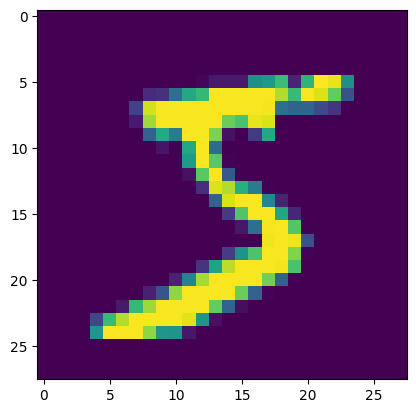

In [3]:
# Load data
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
plt.imshow(mnist_x_train[0])

# Reshape the data to make it suitable for a CNN (# images, image size in pixels (x), image size in pixels (y), # channels)
trainX = mnist_x_train.reshape((mnist_x_train.shape[0], 28, 28, 1 )) / 255
testX = mnist_x_test.reshape((mnist_x_test.shape[0], 28, 28, 1)) / 255

In [4]:
# Data Processing: One hot encode the labels
mnist_y_train = to_categorical(mnist_y_train, num_classes=10)
mnist_y_test = to_categorical(mnist_y_test, num_classes=10)

In [5]:
def residual_block(x, filters, kernel_size=3):
    shortcut = x 

    x = Conv2D(filters, kernel_size=kernel_size, padding="same", activation='relu')(x)
    x = Conv2D(filters, kernel_size=kernel_size, padding="same")(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [6]:
from scikeras.wrappers import KerasClassifier

def create_model(learning_rate=0.003, dropout_rate=0.2):
    input_layer = Input(shape=(28, 28, 1))

    # CNN Architecture
    x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = residual_block(x, filters=32) 
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)

    output_layer = Dense(10, activation='softmax')(x)

    cnn_model = Model(inputs=input_layer, outputs=output_layer)

    # Compile with adjustable learning rate
    optimizer = Adam(learning_rate=learning_rate)
    cnn_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return cnn_model

# Wrap the model for use with scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=0)
cnn_model = create_model()


In [7]:
# Plot Losses callback
import matplotlib.pyplot as plt
from IPython.display import clear_output
import keras


class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val-loss")
        plt.legend()
        plt.show()


plot_losses = PlotLosses()

In [30]:
# Perform hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'model__learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1],
    'batch_size': [32, 64, 128],
    'epochs': [5, 10, 20],
    'model__dropout_rate': [0.2, 0.3, 0.4]
}

# Set up the random search because hyperparameter space is big
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, 
                                   n_iter=10, scoring='accuracy', cv=3, verbose=1)

# Run the search on training data
random_search_result = random_search.fit(mnist_x_train, mnist_y_train)
print(f"Best: {random_search_result.best_score_} using {random_search_result.best_params_}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/tomasward/Desktop/Dev/anaconda3/envs/deep-learning/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/tomasward/Desktop/Dev/anaconda3/envs/deep-learning/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/tomasward/Desktop/Dev/anaconda3/envs/deep-learning/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/tomasward/Desktop/Dev/anaconda3/envs/deep-learning/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will b

Best: 0.9808833333333333 using {'model__learning_rate': 0.003, 'model__dropout_rate': 0.2, 'epochs': 10, 'batch_size': 128}


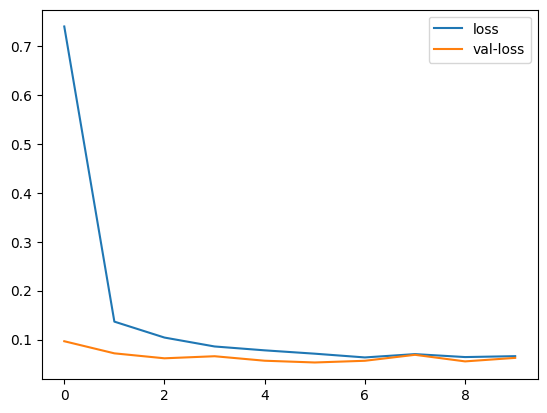

375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9815 - loss: 0.0621 - val_accuracy: 0.9836 - val_loss: 0.0625


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# Fit the model, plotting the loss in real time
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_model.fit(np.array(mnist_x_train), np.array(mnist_y_train), 
                        epochs=10,
                        validation_split = 0.2,
                        batch_size=128,
                        callbacks=[plot_losses, early_stopping])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


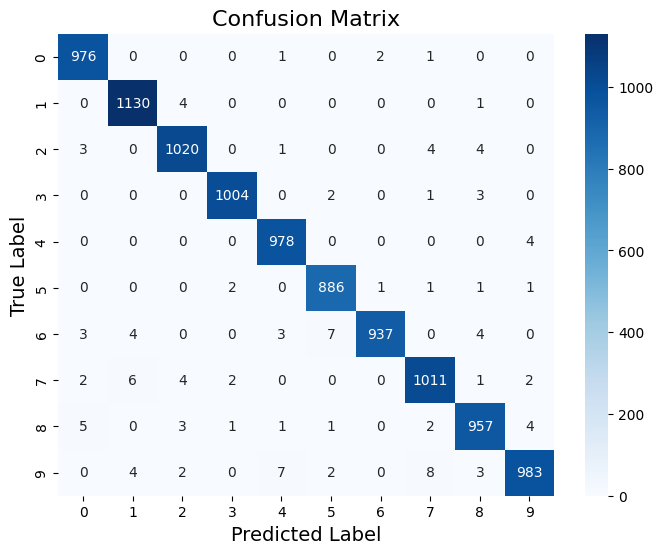

In [10]:
# Evaluate the model with the test set
pred_y=cnn_model.predict(np.array(mnist_x_test))
pred_y=pred_y = np.argmax(pred_y, axis=1)
mnist_y_test_original = np.argmax(mnist_y_test, axis=1)

# Compute the confusion matrix to monitor model performance
m = confusion_matrix(mnist_y_test_original, pred_y)


plt.figure(figsize=(8, 6))
sns.heatmap(m, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

In [11]:
metrics = cnn_model.evaluate(np.array(mnist_x_test), np.array(mnist_y_test))

print(f"Loss: {round(metrics[0],2)}")
print(f"Accuracy: {round(metrics[1] * 100, 2)}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9857 - loss: 0.0507
Loss: 0.04
Accuracy: 98.82%


In [20]:
# Save the model for potential further use
cnn_model.save('cnn_model.keras')

## Random image reader
This codeblock picks a random image from the MNIST Grayscale test set and runs it through the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


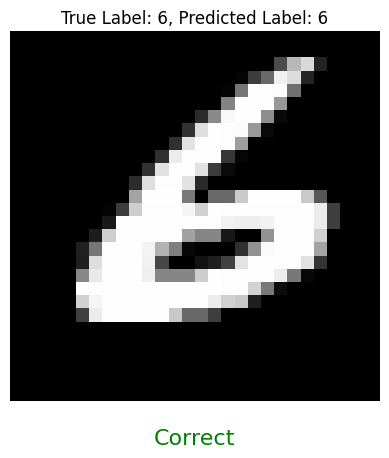

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Pick a random index from the MNIST test set
random_index = random.randint(0, mnist_x_test.shape[0] - 1)
random_image = mnist_x_test[random_index]
true_label = np.argmax(mnist_y_test[random_index])  # Convert one-hot to label


random_image_input = np.expand_dims(random_image, axis=0) 

# Run the model prediction
predicted_probs = cnn_model.predict(random_image_input)
predicted_label = np.argmax(predicted_probs, axis=1)[0]


is_correct = (true_label == predicted_label)

# Display the image
plt.imshow(random_image.squeeze(), cmap='gray')  # Remove channel dimension for display
color = 'green' if is_correct else 'red'
status_text = 'Correct' if is_correct else 'Incorrect'
plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
plt.text(0.5, -0.1, status_text, ha='center', va='center', fontsize=16, color=color, transform=plt.gca().transAxes)
plt.axis('off') 
plt.show()


# Results Comparison
## FNN vs CNN
The fastest model to trian is the simple FNN, because it has to process less information.

However, the most accurate results come from the CNN as it is able to correctly identify spatial features of the image, not only numerical, with feature extraction and convolutional operations.

Residual blocks allow for more generalization in the depth of the network, making results more reliable.